## Jupyter Notebook to test prediction results

This scripts import the dataset then try to plot some results to 

1. Plot ground truth images 
2. Plot prediction images
3. Calculate R and P

### Prepatation

Data Import and Prepare

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
from utils import imageUtils
from utils import postProcessing
from utils import MultiDefectDetectionDataset
from utils import evaluation
from utils import visualization
import numpy as np
import os
from chainercv.links import FasterRCNNVGG16
from chainercv.visualizations import vis_bbox
from chainercv.utils import write_image
import chainer
import math
from chainercv import utils
%matplotlib inline
import matplotlib.pyplot as plt

In [20]:
#load Data
root = './data/Data3TypesYminXminYmaxXmax4'
dataset = MultiDefectDetectionDataset(data_dir=root, split='train')
dataset_test = MultiDefectDetectionDataset(data_dir=root, split='test')
bbox_label_names = ('111', 'dot','100')

In [21]:
# DataSet Statistics
print('total number of training images: ', len(dataset))
print('total number of test images: ', len(dataset_test))
print('type of defects: ', bbox_label_names)

total number of training images:  133
total number of test images:  12
type of defects:  ('111', 'dot', '100')


### Show Data Set

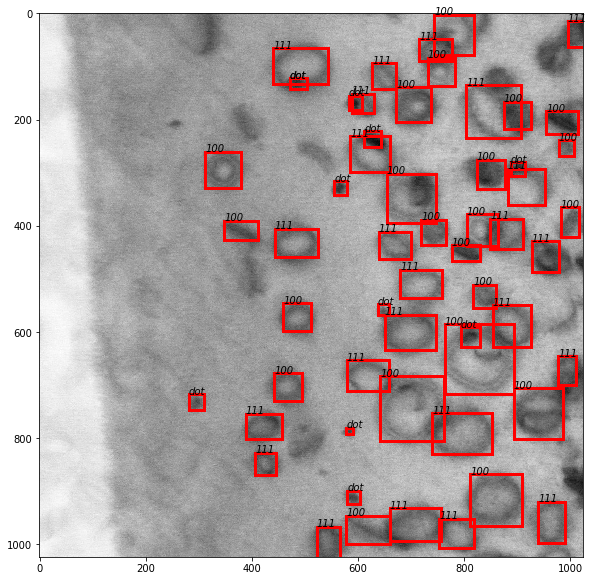

In [5]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[33]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()

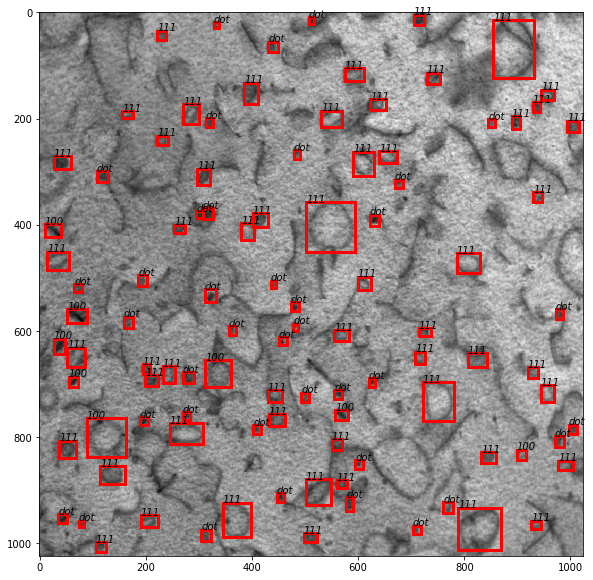

In [24]:
# get image annotation plot by name
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset.get_example_by_name('4ROI_100kx_4100CL_foil1')
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
#plt.show()
plt.savefig('f1.jpg')

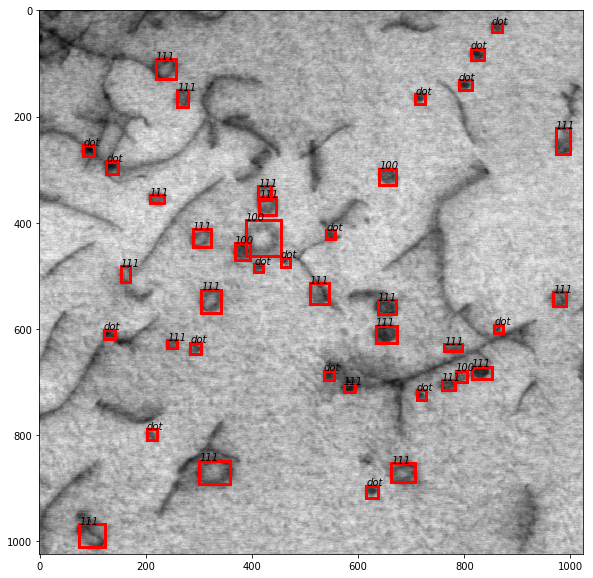

<Figure size 432x288 with 0 Axes>

In [8]:
# Another Figure
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1, 1, 1)
img, bbox, label = dataset[50]
visualization.vis_bbox(img, bbox, label, label_names=bbox_label_names, ax=ax1)
plt.show()



# Testing

Set `use_gpu = False` because we use CPU to do testing

In [7]:
use_gpu = False
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=3, pretrained_model='./modelResults/snapshot_model_100000_dataset4_20180831.npz', ratios=[ 0.5, 1, 1.5, 2, 2.5, 3, 3.5,4],anchor_scales=[1, 4, 8, 16], min_size=1024, max_size=1024,proposal_creator_params=proposal_params)

if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    
bbox_label_names = ('111loop', 'dot','100loop')

#### View Prediction Results

#### First figure

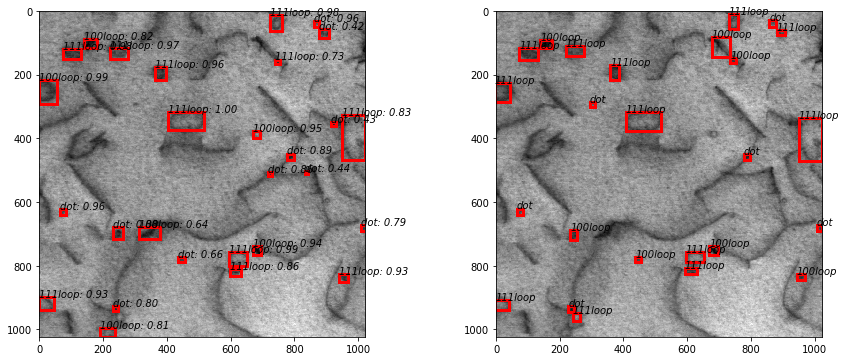

In [21]:
# Prediction of first image
img_1, bbs_1, lbs1 = dataset_test[1]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

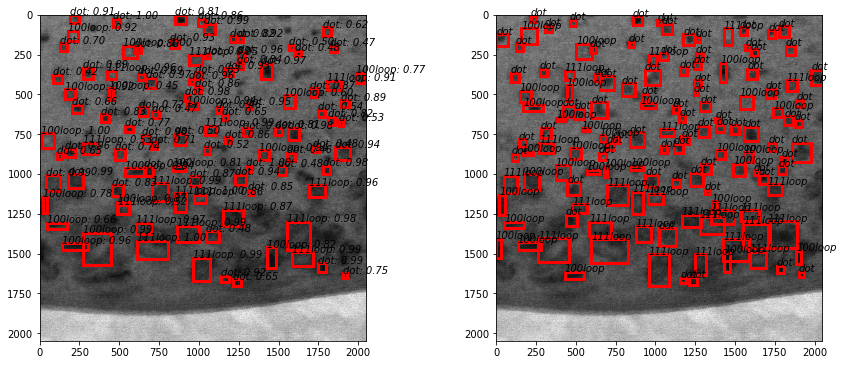

In [23]:
# Prediction of Second image
img_1, bbs_1, lbs1 = dataset_test[10]
model.score_thresh = 0.4
bboxes, labels, scores = model.predict([img_1])
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
# plot prediction
visualization.vis_bbox(img_1, bboxes[0], labels[0], scores[0], label_names=bbox_label_names, ax=ax1)
# plot ground truth
visualization.vis_bbox(img_1, bbs_1, lbs1, label_names=bbox_label_names,ax=ax2)

## Evaluation

In [27]:
use_gpu = False
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=3, pretrained_model='./modelResults/snapshot_model_100000_dataset4_20180831.npz', ratios=[ 0.5, 1, 1.5, 2, 2.5, 3, 3.5,4],anchor_scales=[1, 4, 8, 16], min_size=1024, max_size=1024,proposal_creator_params=proposal_params)

if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    
bbox_label_names = ('111loop', 'dot','100loop')

In [28]:
from utils import evaluate_set_by_centroid
from utils import evaluate_set_by_centroid_kind
from utils import evaluate_set_by_defect_size
from utils import pr_plot_by_size

In [29]:
# Test the code of calculate P and R by the defect kinds instead of just using the overall data
dataset_test_short = MultiDefectDetectionDataset(data_dir=root, split='shorttest')
%time recalls, precisions = evaluate_set_by_centroid_kind(model,bbox_label_names, dataset_test_short, threshold=0.05)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

FileNotFoundError: [Errno 2] No such file or directory: './data/Data3TypesYminXminYmaxXmax4/shorttestimages.txt'

# Validation Set test


In [30]:
use_gpu = False
proposal_params = {'min_size': 8}
model = FasterRCNNVGG16(n_fg_class=3, pretrained_model='./modelResults/snapshot_model_100000_dataset4_20180831.npz', ratios=[ 0.5, 1, 1.5, 2, 2.5, 3, 3.5,4],anchor_scales=[1, 4, 8, 16], min_size=1024, max_size=1024,proposal_creator_params=proposal_params)

if use_gpu:
    chainer.cuda.get_device_from_id(0).use()
    model.to_gpu()
    
bbox_label_names = ('111loop', 'dot','100loop')

In [37]:
# Using Validation Set
dataset_test_validation = MultiDefectDetectionDataset(data_dir=root, split='test')
%time recalls, precisions = evaluate_set_by_centroid(model,dataset_test_validation , threshold=0.1)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))
r = sum(recalls)/len(recalls)
p = sum(precisions)/len(precisions)
print("Average F1", 2 * r * p / (r + p))

CPU times: user 5min 4s, sys: 1min 40s, total: 6min 45s
Wall time: 5min 45s
Average recall  0.8948369864249935
Average precision  0.7119464389084712
Average F1 0.7929830440672441


In [ ]:
%time recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold=0.001)
print("Average recall ", sum(recalls)/len(recalls))
print("Average precision ", sum(precisions)/len(precisions))

In [32]:
# loop over from a list of possible threshold values 
# According to ChainerCV Document
# > algorithm runs with a very low score_thresh so that bounding boxes with low scores are kept. It is known that lower score_thresh produces higher mAP.
# try values from [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
threshodVal = [0.9, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001]
recall_List = list()
precision_List = list()

for valItem in threshodVal:
    print(valItem)
    recalls, precisions = evaluate_set_by_centroid(model, dataset_test, threshold= valItem)
    recall_List.append(sum(recalls)/len(recalls))
    precision_List.append(sum(precisions)/len(precisions) )

0.9


0.5


0.1


0.05


0.01


0.005


0.001


0.0005


0.0001


0.948, 0.196, 0.324
0.790, 0.672, 0.727
0.712, 0.895, 0.793
0.672, 0.901, 0.770
0.627, 0.927, 0.748
0.624, 0.927, 0.746
0.611, 0.932, 0.738
0.609, 0.932, 0.737
0.607, 0.933, 0.736


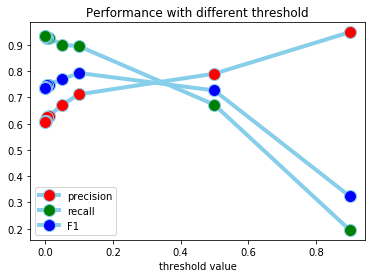

In [34]:
F1_List = list()
for i in range(0,len(recall_List)):
    F1 = (2 * precision_List[i]* recall_List[i])/(precision_List[i]+recall_List[i])
    print("%.3f, %.3f, %.3f" % (precision_List[i],recall_List[i],F1))
    F1_List.append(F1)
    

# Plotting Results
import matplotlib.pyplot as plt
fignow = plt.figure()
plt.plot( threshodVal, precision_List, marker='o', markerfacecolor='red', markersize=12, color='skyblue', linewidth=4, label='precision')
plt.plot( threshodVal, recall_List, marker='o', markerfacecolor='green', markersize=12, color='skyblue', linewidth=4,label='recall')
plt.plot( threshodVal, F1_List, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='F1')
plt.title("Performance with different threshold")
plt.xlabel('threshold value')
plt.legend()
plt.show()
fignow.savefig("F1-model.png",format = "png")



##### Plot Results Summary of different kinds

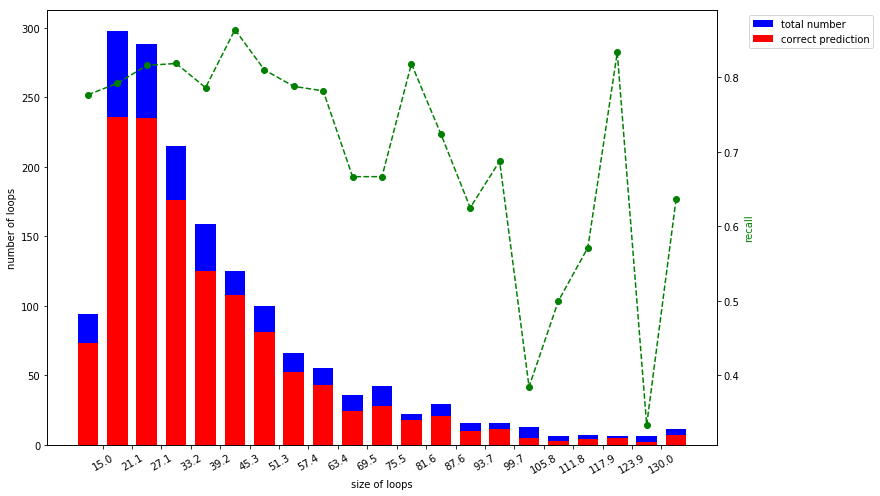

In [14]:
bins = 20
sz_range = (15,130)
recalls, precisions = evaluate_set_by_defect_size(model, dataset_test, num_bins=bins, size_range=sz_range, threshold=0.05)
pr_plot_by_size(recalls, label='recall', num_bins=bins, size_range=sz_range)

In [27]:
import numpy as np

import chainer
from chainer.datasets import TransformDataset
from chainer import training
from chainer.training import extensions
from chainer.training.triggers import ManualScheduleTrigger
from chainercv.extensions import DetectionVOCEvaluator
from chainercv.links import FasterRCNNVGG16
from chainercv.links.model.faster_rcnn import FasterRCNNTrainChain
from chainercv import transforms
from utils import MultiDefectDetectionDataset
from utils import rotate_bbox, random_resize, random_distort, random_crop_with_bbox_constraints
import matplotlib.pyplot as plt
plt.switch_backend('agg')

class Transform(object):
    # initial faster_rcnn
    def __init__(self, faster_rcnn):
        self.faster_rcnn = faster_rcnn
    # Initial datasets, H, W stores the hight and width of the image
    def __call__(self, in_data):
        img, bbox, label = in_data
        _, H, W = img.shape

        # random brightness and contrast
        img = random_distort(img)

        # rotate image
        # return a tuple whose elements are rotated image, param.
        # k (int in param)represents the number of times the image is rotated by 90 degrees.
        img, params = transforms.random_rotate(img, return_param=True)
        # restore the new hight and width
        _, t_H, t_W = img.shape
        # rotate bbox based on renewed parameters
        bbox = rotate_bbox(bbox, (H, W), params['k'])

#         # Random expansion:This method randomly place the input image on
#         # a larger canvas. The size of the canvas is (rH,rW), r is a random ratio drawn from [1,max_ratio].
#         # The canvas is filled by a value fill except for the region where the original image is placed.
        if np.random.randint(2):
            fill_value = img.mean(axis=1).mean(axis=1).reshape(-1,1,1)
            img, param = transforms.random_expand(img, max_ratio=2, fill=fill_value, return_param=True)
            bbox = transforms.translate_bbox(bbox, y_offset=param['y_offset'], x_offset=param['x_offset'])

#       # Random crop
#       # crops the image with bounding box constraints
        img, param = random_crop_with_bbox_constraints(img, bbox, min_scale=0.75, max_aspect_ratio=1.25, return_param=True)
#         # this translates bounding boxes to fit within the cropped area of an image, bounding boxes whose centers are outside of the cropped area are removed.
        bbox, param = transforms.crop_bbox(bbox, y_slice=param['y_slice'], x_slice=param['x_slice'],allow_outside_center=False, return_param=True)
#         #assigning new labels to the bounding boxes after cropping
        label = label[param['index']]
#       # if the bounding boxes are all removed,
        if bbox.shape[0] == 0:
            img, bbox, label = in_data
#         # update the height and width of the image
        _, t_H, t_W = img.shape

        img = self.faster_rcnn.prepare(img)
        # prepares the image to match the size of the image to be input into the RCNN
        _, o_H, o_W = img.shape
        # resize the bounding box according to the image resize
        bbox = transforms.resize_bbox(bbox, (t_H, t_W), (o_H, o_W))

        # horizontally & vertical flip
        # simutaneously flip horizontally and vertically of the image
        img, params = transforms.random_flip(
            img, x_random=True, y_random=True, return_param=True)
        # flip the bounding box with respect to the parameter
        bbox = transforms.flip_bbox(
            bbox, (o_H, o_W), x_flip=params['x_flip'], y_flip=params['y_flip'])
        
        scale = o_H / t_H

        return img, bbox, label, scale

In [34]:
# Data Augmentation
train_data = TransformDataset(dataset, Transform(model))

In [35]:
print(len(dataset))

64


In [36]:
print(len(train_data))

64


In [ ]:
import os
print(os.getcwd())